In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

In [2]:
TOPICS = ["Astronomy", "Health", "Economy"]
TOPICS_MAP = {"Astronomy": 0, "Health": 1, "Economy": 2}

In [5]:
def create_dataset(topics):
    data = {'hash':[],'topic': [], 'text': []}
    for topic in topics:
        for file in os.listdir(f"Documents/{topic}"):
            with open(f"Documents/{topic}/{file}", "r", encoding="utf-8") as f:
                text = f.read()
                data['hash'].append(file)
                data['topic'].append(topic)
                data['text'].append(text)
    return pd.DataFrame(data)

data = create_dataset(TOPICS)
data

,hash,topic,text
0,070c9fd24e43ba164f3a68dd8c976a57461fceb038a43d...,Astronomy,cosmic countdown begun director james gunn ’ `...
1,09559783f5ee1852885289ba8fd16625284625dd41875e...,Astronomy,planetary society taking stand nasa 's stalled...
2,09d01585d21facc6f893ec9c64a6d79ffc107be243f10d...,Astronomy,may helpful receive news updates notifications...
3,0a3d8dfb0821ff1ed7ad6fd00ad318c667f9300b37ea71...,Astronomy,spacex falcon 9 rocket used first stage launch...
4,111ab5bb8e4daf91448b849d23e91da843ff026e4803b1...,Astronomy,son 's 40-year-old sketch astronaut dad 's mis...
...,...,...,...
160,e2603ae7220618cf35de8713015bf5d225d0cb97765e0b...,Economy,amazon-owned audible started putting ads audio...
161,e502123029685fc536e71460d80a5a430d94062a51ab90...,Economy,tuesday 's budget included new money create na...
162,e558e08d8462e014b1e55f2e08f8a16f9f4d891b74c031...,Economy,raymond james says collected responses 48 cana...
163,e9cdffafbe7284b1a428ec912e065ba17127264fa1737b...,Economy,surge stock could driven idea indictment bad n...


In [6]:
def preprocess(data,topics_map):
    tokenizer = RegexpTokenizer(r'\w+')
    data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['text'] = data['text'].apply(lambda x: ' '.join(x))
    data['label'] = data['topic'].map(topics_map)
    X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess(data,TOPICS_MAP)
X_train

83     disclaimerhealthline media inc digital publish...
24     looking versatile mobile camera setup want kee...
151    11 30 et 15 30 gmt new york traded west texas ...
86     us journey health wellness right feel affects ...
19     dusk first night march spectacular action sout...
                             ...                        
9      falcon 9 s first stage making fourth flight li...
103    crohn disease affects gi tract leading symptom...
67     melatonin hormone body produces naturally sign...
117    bill ackman warns pausing ai development help ...
47     nasa astronaut collins retired colonel u s air...
Name: text, Length: 132, dtype: object

In [7]:
def create_tf_idf(X_train,X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf
X_train_tfidf, X_test_tfidf = create_tf_idf(X_train,X_test)
X_train_tfidf

<132x15525 sparse matrix of type '<class 'numpy.float64'>'
	with 56941 stored elements in Compressed Sparse Row format>

In [8]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_validate_and_train(model,X_train_tfidf,y_train):
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score,average='macro'),
           'recall': make_scorer(recall_score, average='macro'),
           'f1_score': make_scorer(f1_score, average='macro')}
    K_folds = 5
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=K_folds, scoring=scoring, return_estimator=True)
    for i in range(K_folds):
        print(f"Fold: {i+1}")
        print(f"Accuracy: {cv_results['test_accuracy'][i]}")
        print(f"Precision: {cv_results['test_precision'][i]}")
        print(f"Recall: {cv_results['test_recall'][i]}")
        print(f"F1 Score: {cv_results['test_f1_score'][i]}")
        print("\n")
    print("Mean Metrics")
    print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
    print(f"Mean Precision: {np.mean(cv_results['test_precision'])}")
    print(f"Mean Recall: {np.mean(cv_results['test_recall'])}")
    print(f"Mean F1 Score: {np.mean(cv_results['test_f1_score'])}")

    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    best_metric = max(mean_scores, key=mean_scores.get)
    best_estimator_index= np.argmax(cv_results['test_'+best_metric])
    best_estimator = cv_results['estimator'][best_estimator_index]
    print(f"Best Estimator: {best_estimator_index}")
    return best_estimator

In [9]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, RocCurveDisplay
def test_model(model,X_test_tfidf,y_test, plot=False):
    print("Test Metrics")
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    if plot:
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
        plt.show()
    return report

Model: SVC
Fold: 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 2
Accuracy: 0.9629629629629629
Precision: 0.9666666666666667
Recall: 0.9629629629629629
F1 Score: 0.9628482972136223


Fold: 3
Accuracy: 0.9230769230769231
Precision: 0.9393939393939394
Recall: 0.9212962962962963
F1 Score: 0.9248366013071895


Fold: 4
Accuracy: 0.9615384615384616
Precision: 0.9666666666666667
Recall: 0.9583333333333334
F1 Score: 0.960233918128655


Fold: 5
Accuracy: 0.9615384615384616
Precision: 0.9666666666666667
Recall: 0.9629629629629629
F1 Score: 0.9628482972136223


Mean Metrics
Mean Accuracy: 0.9618233618233619
Mean Precision: 0.967878787878788
Mean Recall: 0.961111111111111
Mean F1 Score: 0.9621534227726178
Best Estimator: 0
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.85      1.00      0.92        11
           2       1.00      0.83      0.91        12

    accuracy                  

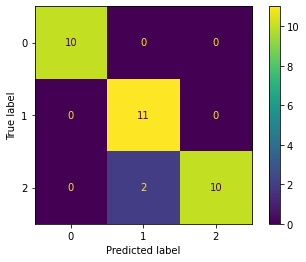



Model: KNeighborsClassifier
Fold: 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 5
Accuracy: 0.9615384615384616
Precision: 0.9666666666666667
Recall: 0.9629629629629629
F1 Score: 0.9628482972136223


Mean Metrics
Mean Accuracy: 0.9923076923076923
Mean Precision: 0.9933333333333334
Mean Recall: 0.9925925925925926
Mean F1 Score: 0.9925696594427244
Best Estimator: 0
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



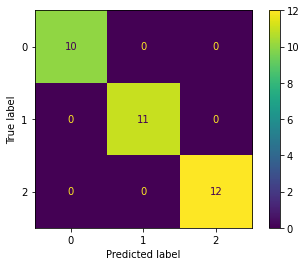



Model: DecisionTreeClassifier
Fold: 1
Accuracy: 0.8148148148148148
Precision: 0.825925925925926
Recall: 0.8148148148148149
F1 Score: 0.8185987845430569


Fold: 2
Accuracy: 0.9259259259259259
Precision: 0.9259259259259259
Recall: 0.9259259259259259
F1 Score: 0.9259259259259259


Fold: 3
Accuracy: 0.8461538461538461
Precision: 0.8653198653198654
Recall: 0.8472222222222222
F1 Score: 0.8411764705882354


Fold: 4
Accuracy: 0.9230769230769231
Precision: 0.9212962962962963
Recall: 0.9212962962962963
F1 Score: 0.9212962962962963


Fold: 5
Accuracy: 0.8461538461538461
Precision: 0.8468013468013469
Recall: 0.8379629629629629
F1 Score: 0.8343915343915344


Mean Metrics
Mean Accuracy: 0.8712250712250711
Mean Precision: 0.8770538720538721
Mean Recall: 0.8694444444444445
Mean F1 Score: 0.8682778023490098
Best Estimator: 1
Test Metrics
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.69      0.82      0.75        11
  

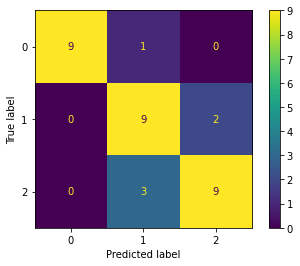



Model: LogisticRegression
Fold: 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 2
Accuracy: 0.9629629629629629
Precision: 0.9666666666666667
Recall: 0.9629629629629629
F1 Score: 0.9628482972136223


Fold: 3
Accuracy: 0.9615384615384616
Precision: 0.9666666666666667
Recall: 0.9629629629629629
F1 Score: 0.9628482972136223


Fold: 4
Accuracy: 0.9615384615384616
Precision: 0.9666666666666667
Recall: 0.9583333333333334
F1 Score: 0.960233918128655


Fold: 5
Accuracy: 0.9615384615384616
Precision: 0.9666666666666667
Recall: 0.9629629629629629
F1 Score: 0.9628482972136223


Mean Metrics
Mean Accuracy: 0.9695156695156696
Mean Precision: 0.9733333333333334
Mean Recall: 0.9694444444444444
Mean F1 Score: 0.9697557619539043
Best Estimator: 0
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

    accurac

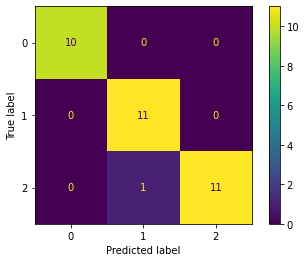

In [10]:
def train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test):
    models = [SVC(),KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression()]
    reports = {}
    for model in models:
        print(f"Model: {model.__class__.__name__}")
        best_estimator = cross_validate_and_train(model,X_train_tfidf,y_train)
        report = test_model(best_estimator,X_test_tfidf,y_test,plot=True)
        reports[model.__class__.__name__] = [best_estimator,report]
        print("\n")
    return reports
reports = train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test)

In [11]:
def choose_best_model(reports):
    #Choose best model based on highest accuracy, precision, recall and f1 score
    best_model = None
    best_score = 0
    model_name = None
    for model in reports:
        report = reports[model][1]
        score = report['accuracy'] + report['macro avg']['precision'] + report['macro avg']['recall'] + report['macro avg']['f1-score']
        if score > best_score:
            best_score = score
            best_model = reports[model][0]
            model_name = model
    return model_name, best_model
model_name, best_model = choose_best_model(reports)
print(f"Best Model: {model_name}")

Best Model: KNeighborsClassifier


In [12]:
probs = best_model.predict_proba(X_test_tfidf)
for prob in probs:
    print(prob)

[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0.2 0.8 0. ]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0.2 0.6 0.2]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0.  0.8 0.2]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0.2 0.  0.8]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]


In [13]:
# def save_model(model):
#     joblib.dump(model, "classifier.joblib")